# Building the model

In [1]:
import os
import json

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import preproc

In [2]:
N_EPOCHS = 200
BATCH_SIZE = 64

cols = ['latitude', 'longitude', 'timestamp']

## Load the dataset

In [3]:
data_dir = 'dataset/reduced_preprocessed'
train = np.load(os.path.join(data_dir, 'train.npy'))
valid = np.load(os.path.join(data_dir, 'valid.npy'))
test = np.load(os.path.join(data_dir, 'test.npy'))

bounds = {}
bounds_path = os.path.join(data_dir, 'bounds.json')
with open(bounds_path) as file:
    bounds = json.load(file)

# Create the model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

event_vec_dim = train.shape[-1]
seq_len = preproc.WINDOW_SIZE
hidden_dim = 1024
num_layers = 4

In [5]:
from lstm_model import FirePredictor

# create the model
model = FirePredictor(event_vec_dim, seq_len, hidden_dim, num_layers)

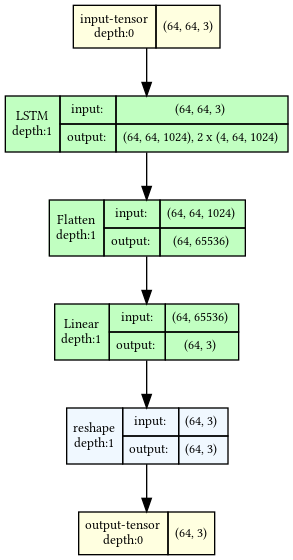

In [6]:
# visualize model structure
# This uses torchview, which is a library outside of pytorch for visualizing torch.nn.Modules
# https://github.com/mert-kurttutan/torchview
import graphviz
graphviz.set_jupyter_format('png')

from torchview import draw_graph
model_graph = draw_graph(model, input_size=(BATCH_SIZE, seq_len, event_vec_dim), device='cuda')
model_graph.visual_graph

## Write the loss function

In [7]:
# def euclidean_dist(t1, t2, dim):
#     return (t1 - t2).pow(2).sum(dim).sqrt()
#
# def avg_distance(x, y):
#     if x.isnan().any():
#         print(x)
#         raise RuntimeError("Loss func: x contains NAN")
#     # use nearest neighbor upsampling
#     reshaped = torch.nn.functional.interpolate(x[:,:,None,:], size=y.shape[2:], mode='nearest')
#     if reshaped.isnan().any():
#         print(reshaped)
#         raise RuntimeError("Loss func: reshaped x contains NAN")
#     result = (euclidean_dist(reshaped, y, dim=2)).sum() / np.array(y.shape[0:-1]).prod()
#     if result.isnan().any():
#         print(result)
#         raise RuntimeError("Loss func: result contains NAN")
#     return result
#
#
# x = torch.Tensor(sequences[0:3,0:64,0,:])
# y = torch.Tensor(sequences[0:3,0:64,1:,:])
#
# print(avg_distance(torch.Tensor(x), torch.Tensor(y)))
# print(f'{x.shape=}, {y.shape=}')

## Prepare Optimizer, Scheduler, and Data Loader

In [8]:
# split train & validation data into inputs and labels
x_train = torch.Tensor(train[:,:preproc.WINDOW_SIZE,:])
y_train = torch.Tensor(train[:,preproc.WINDOW_SIZE,:])

x_valid = torch.Tensor(valid[:,:preproc.WINDOW_SIZE,:]).to(device)
y_valid = torch.Tensor(valid[:,preproc.WINDOW_SIZE,:]).to(device)

In [9]:
print(f'{x_valid.shape=}, {y_valid.shape}')

x_valid.shape=torch.Size([161, 64, 3]), torch.Size([161, 3])


In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

loss_function = nn.MSELoss()

/home/cynthia/.local/lib/python3.10/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/cynthia/.local/lib/python3.10/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


## Training Loop

In [11]:
losses_valid = np.zeros(N_EPOCHS)
losses_train = np.zeros(N_EPOCHS)

for epoch in range(N_EPOCHS):
    # loop over batches
    acc_train_loss = 0.0
    for i, data in enumerate(data_loader):

        x_batch, y_batch = data
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        preds = model(x_batch)

        loss = loss_function(preds, y_batch)
        acc_train_loss += loss
        loss.backward()

        optimizer.step()

    # record average loss of all batches in this epoch
    losses_train[epoch] = acc_train_loss / (x_train.shape[0]/BATCH_SIZE)

    # compute validation loss
    model.eval()
    with torch.no_grad():
        v_preds = model(x_valid)
        losses_valid[epoch] = loss_function(v_preds, y_valid).item()
    model.train()

    # print out the losses so we can see it update as we train
    print(f'Epoch {epoch} -- train loss: {losses_train[epoch]} valid loss: {losses_valid[epoch]}')

Epoch 0 -- train loss: 0.11224173754453659 valid loss: 0.09747140854597092
Epoch 1 -- train loss: 0.07946192473173141 valid loss: 0.1069600060582161
Epoch 2 -- train loss: 0.0651983916759491 valid loss: 0.10778030008077621
Epoch 3 -- train loss: 0.06341518461704254 valid loss: 0.10091683268547058
Epoch 4 -- train loss: 0.059681300073862076 valid loss: 0.1030145213007927
Epoch 5 -- train loss: 0.06003124639391899 valid loss: 0.10278930515050888
Epoch 6 -- train loss: 0.059681788086891174 valid loss: 0.09912153333425522
Epoch 7 -- train loss: 0.05861954391002655 valid loss: 0.10689041018486023
Epoch 8 -- train loss: 0.05932401493191719 valid loss: 0.09961399435997009
Epoch 9 -- train loss: 0.05851781368255615 valid loss: 0.10497324168682098
Epoch 10 -- train loss: 0.059649787843227386 valid loss: 0.09907220304012299
Epoch 11 -- train loss: 0.059899527579545975 valid loss: 0.10633406788110733
Epoch 12 -- train loss: 0.05883870646357536 valid loss: 0.10172692686319351
Epoch 13 -- train los

KeyboardInterrupt: 

In [ ]:
model(x_train[0][None, :, :].to(device))

## Analyze the results

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses_train, label='train loss')
plt.plot(losses_valid, label='validation loss', color='r')
plt.legend()

plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    res = model(x_train[0:128].to(device)).cpu().detach()
    res = pd.DataFrame(res, columns=cols)

prediction = preproc.unprocess(res, bounds)
actual = preproc.unprocess(pd.DataFrame(y_train[0:128].numpy(), columns=cols), bounds)

display(prediction)
display(actual)

In [ ]:
display(prediction.sort_values('timestamp'))
display(actual.sort_values('timestamp'))

In [ ]:
display(prediction.std(axis=0))
display(actual.std(axis=0))

# Save the model's state_dict to a JSON file to evaluate later

In [ ]:
model_path = "models/reduced_lstm.json"
model.to_json(model_path)

In [ ]:
# load the model, just to be sure that we can
model.from_json(model_path)

In [ ]:
model.eval()
with torch.no_grad():
    res = model(x_train[0:128].to(device)).cpu().detach()
    res = pd.DataFrame(res, columns=cols)

pred2 = preproc.unprocess(res, bounds)

In [ ]:
display(prediction.sort_values('timestamp'))
display(pred2.sort_values('timestamp'))